In [1]:
# Step 1: Import basic libraries
import pandas as pd
import numpy as np

# For visual inspection
pd.set_option('display.max_columns', None)

# Read the Excel file
df = pd.read_excel("IterLight_Aspen_Enhanced_Dataset.xlsx")

# Quick look at the data
df.info()
df.head(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Organization                     200 non-null    object
 1   Category                         200 non-null    object
 2   Tier                             200 non-null    int64 
 3   Geographic Scope                 200 non-null    object
 4   Mission / Stated Pillars         200 non-null    object
 5   Verified Grant URL / Contact     200 non-null    object
 6   Confirmed Application Deadlines  197 non-null    object
 7   Typical Grant Size               189 non-null    object
 8   Strategic Note / Pitch Angle     147 non-null    object
 9   DEI Priorities                   200 non-null    object
 10  Partnership Potential            200 non-null    object
 11  Best Pitch Angle                 200 non-null    object
 12  Enhanced Notes                   147

,Organization,Category,Tier,Geographic Scope,Mission / Stated Pillars,Verified Grant URL / Contact,Confirmed Application Deadlines,Typical Grant Size,Strategic Note / Pitch Angle,DEI Priorities,Partnership Potential,Best Pitch Angle,Enhanced Notes,Contact Person,Application Process
0,Kickstarter,Crowdfunding,3,National,"Platform for creative, project-based funding w...",https://www.kickstarter.com/,Rolling,$1K - $10K+,"Best for a specific, tangible project (e.g., '...",Likely - Verify,Community integration,Sports-math curriculum,Best for project-based funding with tangible r...,https://www.kickstarter.com/,Rolling
1,Indiegogo,Crowdfunding,3,National,Similar to Kickstarter but offers more flexibl...,https://www.indiegogo.com/,Rolling,$1K - $10K+,"A strong alternative to Kickstarter, especiall...",Likely - Verify,Community integration,Sports-math curriculum,Similar to Kickstarter but offers more flexibl...,https://www.indiegogo.com/,Rolling
2,University of Florida Foundation,Collegiate,1,Florida,"Supports UF's mission of research, education, ...","Kim Kruse, Corporate & Foundation Giving: ktk@...",Varies; partnership-based,Varies ($5K - $50K+),LOCAL ADVANTAGE. Propose a research partnershi...,Likely - Verify,Pilot programs,College prep through sports learning,Directly approaching the Corporate & Foundatio...,"Kim Kruse, Corporate & Foundation Giving: ktk@...",Research needed


In [2]:
# View a few random examples
df['Typical Grant Size'].sample(10, random_state=42)


95                    Varies ($5K-25K)
15     $5k, $10k, $15k, or $20k levels
30                              Varies
158                             Varies
128                             Varies
115                             Varies
69       Varies ($20k - $60k examples)
170                             Varies
174                             Varies
45                      Transformative
Name: Typical Grant Size, dtype: object

In [3]:
# See how many distinct values and their counts
df['Typical Grant Size'].value_counts(dropna=False).head(20)


Typical Grant Size
Varies                                                   115
Varies ($5K-25K)                                          14
NaN                                                       11
Varies (e.g                                                7
Varies ($5K - $25K+)                                       3
Varies ($5K - $50K+)                                       2
$1K - $10K+                                                2
To be determined                                           2
Varies (Large)                                             2
50                                                         1
Pistons Neighbors Program application due Mar 24)          1
Partnership-based                                          1
Varies ($5k rapid-response grants via Fastball Fund)       1
Significant ($4B+ committed over 5 years for Elevate)      1
Varies by program (e.g                                     1
Grant applications are typically by invitation             1
Varie

In [4]:
import re
import numpy as np

def classify_grant_size(x):
    """
    Classify grant size text into 4 categories:
    1 = Explicit numeric range or single amount (e.g. '$5K-$25K')
    2 = 'Varies' but contains numeric info (e.g. 'Varies ($5K-$25K+)')
    3 = 'Varies' or descriptive text without numbers
    4 = Missing, irrelevant, or invalid (dates, non-grant text)
    """
    if pd.isna(x) or str(x).strip() == "":
        return 4

    text = str(x).lower()
    has_number = bool(re.search(r'\d+', text))

    if has_number and 'varies' not in text:
        return 1
    elif has_number and 'varies' in text:
        return 2
    elif not has_number and 'varies' in text:
        return 3
    else:
        return 4

df['GrantSize_Class'] = df['Typical Grant Size'].apply(classify_grant_size)

# Check results
df[['Typical Grant Size', 'GrantSize_Class']].sample(10, random_state=42)
df['GrantSize_Class'].value_counts().sort_index()


GrantSize_Class
1     22
2     30
3    126
4     22
Name: count, dtype: int64

In [5]:
df.columns.tolist()


['Organization',
 'Category',
 'Tier',
 'Geographic Scope',
 'Mission / Stated Pillars',
 'Verified Grant URL / Contact',
 'Confirmed Application Deadlines',
 'Typical Grant Size',
 'Strategic Note / Pitch Angle',
 'DEI Priorities',
 'Partnership Potential',
 'Best Pitch Angle',
 'Enhanced Notes',
 'Contact Person',
 'Application Process',
 'GrantSize_Class']

In [6]:
# Step 4: Select relevant columns for clustering
cols_to_use = [
    'Organization',
    'Category',
    'Geographic Scope',
    'Mission / Stated Pillars',
    'GrantSize_Class'
]

df_clust = df[cols_to_use].copy()

# Add a unique numeric index for each organization
df_clust.reset_index(drop=True, inplace=True)
df_clust['Org_ID'] = df_clust.index + 1  # start from 1 for readability

# Reorder columns so ID is first
df_clust = df_clust[['Org_ID'] + cols_to_use]

# Inspect
df_clust.head(5)


,Org_ID,Organization,Category,Geographic Scope,Mission / Stated Pillars,GrantSize_Class
0,1,Kickstarter,Crowdfunding,National,"Platform for creative, project-based funding w...",1
1,2,Indiegogo,Crowdfunding,National,Similar to Kickstarter but offers more flexibl...,1
2,3,University of Florida Foundation,Collegiate,Florida,"Supports UF's mission of research, education, ...",2
3,4,Florida State University Research Foundation,Collegiate,Florida,The 'Grants for Application Proof of Concept (...,2
4,5,NFL Foundation,Pro Sports League,National,"Supports health, safety, and wellness of athle...",3


In [ ]:
!pip install sentence-transformers


In [8]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load a lightweight general-purpose embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate 384-dimensional embeddings for each mission statement
text_embeddings = model.encode(df_clust['Mission / Stated Pillars'].fillna(''), show_progress_bar=True)

# Confirm the shape
print("Embeddings shape:", text_embeddings.shape)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Embeddings shape: (200, 384)


In [12]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Convert all categorical columns to string to avoid mixed-type errors
cat_features = df_clust[['Geographic Scope', 'GrantSize_Class']].astype(str)

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_encoded = encoder.fit_transform(cat_features)

print("Categorical feature names:", encoder.get_feature_names_out())
print("Categorical shape:", cat_encoded.shape)


Categorical feature names: ['Geographic Scope_2' 'Geographic Scope_Akron, OH'
 'Geographic Scope_Alabama'
 'Geographic Scope_Alameda & San Francisco Counties, CA'
 'Geographic Scope_Alberta' 'Geographic Scope_Arizona'
 'Geographic Scope_Atlanta' 'Geographic Scope_Austin'
 'Geographic Scope_Baltimore' 'Geographic Scope_Bay Area'
 'Geographic Scope_Bay Area, CA' 'Geographic Scope_Birmingham'
 'Geographic Scope_British Columbia' 'Geographic Scope_Brooklyn'
 'Geographic Scope_Central Florida' 'Geographic Scope_Central Texas'
 'Geographic Scope_Charleston' 'Geographic Scope_Charlotte'
 'Geographic Scope_Chicago' 'Geographic Scope_Chicago, IL & Northwest IN'
 'Geographic Scope_Chicagoland Area' 'Geographic Scope_Colorado'
 'Geographic Scope_Colorado Springs' 'Geographic Scope_Columbus'
 'Geographic Scope_D.C. Area' 'Geographic Scope_D.C. Metro Area'
 'Geographic Scope_DMV Area' 'Geographic Scope_Dallas-Fort Worth Area'
 'Geographic Scope_Delaware Valley' 'Geographic Scope_Detroit'
 'Geograph

In [13]:
from numpy import hstack
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 7a: Combine text embeddings + categorical encodings
X = hstack([text_embeddings, cat_encoded])
print("Final feature matrix shape:", X.shape)

# Step 7b: Try KMeans for a few cluster counts
sil_scores = {}
for k in range(2, 9):  # test k = 2 to 8
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores[k] = score
    print(f"k={k}, silhouette score={score:.3f}")

# Step 7c: Pick the best k (highest silhouette score)
best_k = max(sil_scores, key=sil_scores.get)
print(f"\nBest number of clusters: {best_k}")


Final feature matrix shape: (200, 517)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/jovitagandhi/opt/anaconda3/envs/video/lib/python3.10/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


k=2, silhouette score=0.159
k=3, silhouette score=0.179
k=4, silhouette score=0.204
k=5, silhouette score=0.138
k=6, silhouette score=0.114
k=7, silhouette score=0.111
k=8, silhouette score=0.102

Best number of clusters: 4


In [14]:
# Step 8a: Run KMeans again with the optimal number of clusters
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_clust['Cluster'] = kmeans.fit_predict(X)

# Step 8b: See how many orgs in each cluster
df_clust['Cluster'].value_counts().sort_index()


Cluster
0    126
1     22
2     22
3     30
Name: count, dtype: int64

In [15]:
for c in sorted(df_clust['Cluster'].unique()):
    subset = df_clust[df_clust['Cluster'] == c]
    print(f"\n=== Cluster {c} ===")
    print("Organizations:", len(subset))
    print("Most common Grant Size Classes:")
    print(subset['GrantSize_Class'].value_counts())
    print("\nSample Missions:")
    print(subset['Mission / Stated Pillars'].head(3).tolist())



=== Cluster 0 ===
Organizations: 126
Most common Grant Size Classes:
GrantSize_Class
3    126
Name: count, dtype: int64

Sample Missions:
['Supports health, safety, and wellness of athletes; youth football development; social justice', "Educate and empower Bay Area youth'; Social Justice grant focuses on racial equity in the Black community via education, economic advancement, and criminal justice reform", "Pillars: Wellness, Education, Youth Hockey. Specific programs include 'Technology in Education' and 'PensFIT'"]

=== Cluster 1 ===
Organizations: 22
Most common Grant Size Classes:
GrantSize_Class
4    22
Name: count, dtype: int64

Sample Missions:
['Pillars: Education, Health Care, Homelessness, Youth Development. Strong focus on STEM, literacy, and college readiness', 'Make soccer accessible and inclusive; stress physical fitness, play, and sportsmanship. Explicitly supports STEM programs', "Use soccer as a 'vehicle to inspire health, learning, and joy'"]

=== Cluster 2 ===
Organ

In [ ]:
!pip install umap-learn matplotlib


/Users/jovitagandhi/opt/anaconda3/envs/video/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


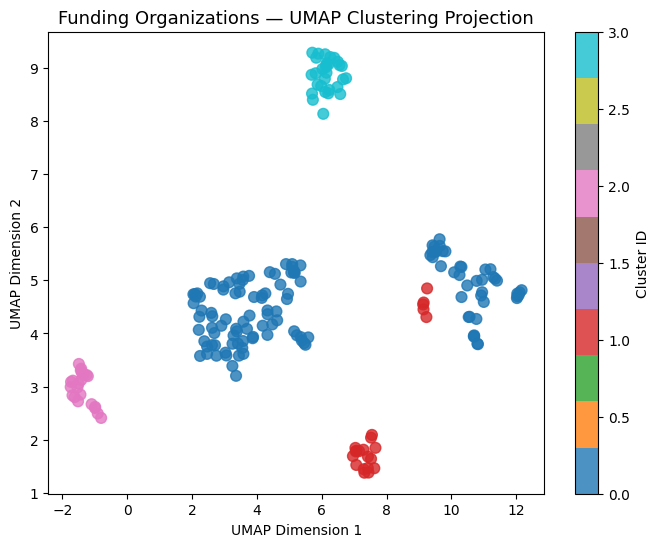

In [18]:
from umap import UMAP
import matplotlib.pyplot as plt

# Step 9a: Reduce to 2D
umap = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding_2d = umap.fit_transform(X)

# Step 9b: Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    embedding_2d[:,0], embedding_2d[:,1],
    c=df_clust['Cluster'], cmap='tab10', s=60, alpha=0.8
)
plt.title("Funding Organizations — UMAP Clustering Projection", fontsize=13)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(scatter, label="Cluster ID")
plt.show()


# What's next?
- Should we include more?
- Is the one hot encoding etc okay and make sense? 
- info about IterLight, so we can start mathcing up 
- Need to find out more about what each cluster is like

